In [1]:
import torch
import configparser
import control
from customDatasetMakers import state_to_dic
from dataSettings import get_denormalized_dic, get_normalized_dic
from customModels import IanRNN, HiroLinear, HiroLRAN
from train_helpers import get_state_mask, get_sample_time_state_mask, masked_loss
import numpy as np
from scipy.sparse import csr_matrix
import customDatasetMakers
import matplotlib.pyplot as plt
import prediction_helpers
import osqp
import scipy as sp
from scipy import sparse


/home/hf8585/.conda/envs/torch/lib/python3.11/site-packages/torch/utils/_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


In [2]:
#lstm_model_name = 'HiroLRAN_alldiiid'
lstm_model_name = 'alldiiid_ensemble'
linear_model_name = 'HiroLRAN_alldiiid'
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{lstm_model_name}config'
config=configparser.ConfigParser()
config.read(config_filename)
output_filename_base=config['model']['output_filename_base']
profiles=config['inputs']['profiles'].split()
actuators=config['inputs']['actuators'].split()
parameters=config['inputs'].get('parameters','').split()
calculations=config['inputs'].get('calculations','').split()
config_filename = f'/projects/EKOLEMEN/profile_predictor/joe_hiro_models/{linear_model_name}config'
config_linear=configparser.ConfigParser()
config_linear.read(config_filename)
controller_actuators = config_linear['inputs']['actuators'].split()
controller_profiles = config_linear['inputs']['profiles'].split()
controller_parameters = config_linear['inputs']['parameters'].split()
latent_dim = int(config_linear['HiroLRAN']['latent_dim'])
data_filename = config['preprocess']['preprocessed_data_filenamebase'] + 'val.pkl'

In [3]:
import pickle
index = 21
with open(f'control_pickles/{lstm_model_name}{linear_model_name}{index}.pkl', 'rb') as f:
    control_model = pickle.load(f)
print(control_model['controlled'].keys())

dict_keys(['zipfit_etempfit_rho', 'zipfit_itempfit_rho', 'zipfit_trotfit_rho', 'zipfit_edensfit_rho', 'qpsi_EFIT01', 'pinj', 'tinj', 'ip', 'bt', 'D_tot', 'ech_pwr_total', 'tribot_EFIT01', 'tritop_EFIT01', 'kappa_EFIT01', 'aminor_EFIT01', 'volume_EFIT01', 'rmaxis_EFIT01'])


[0.99692374, 2.7765884, 0.6893911, 3.8168437, 1.7216603, 4.1709704, 0.85777515, 1.8323077, 2.6287522, 2.0762022, 0.9852279, 1.1393634, 0.6617722, 3.5712812, 1.291104, 2.7270064, 3.4414372, 3.6260333, 0.00021461915, 5.682437, 3.184975, 3.5879767, 3.1983008, 5.0290513, 1.5780728, 1.3710977, 1.6308119, 1.3260424, 1.3289186, 1.5346293, 4.920352, 2.7163997, 4.7152767, 1.3983262, 2.500244, 1.454278, 4.958758, 2.0236661, 3.147731, 2.2306523]


Text(0.5, 1.0, 'Timeseries of 40 latent space variables')

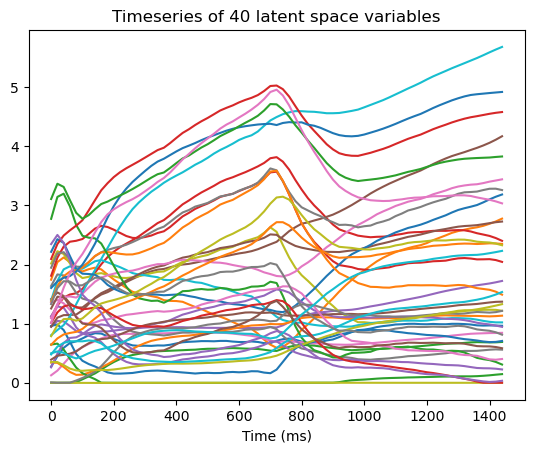

In [9]:
latent_space = np.array(control_model['latent'])
latent_size = []
for i in range(len(latent_space[0,0,0])):
    plt.plot(np.arange(0, len(latent_space))*20, latent_space[:,0,0,i])
    #latent_size.append(1/np.abs(max(latent_space[:,0,0,i])))
    latent_size.append(np.abs(max(latent_space[:,0,0,i])))
    plt.xlabel('Time (ms)')
print(latent_size)
plt.title('Timeseries of 40 latent space variables')

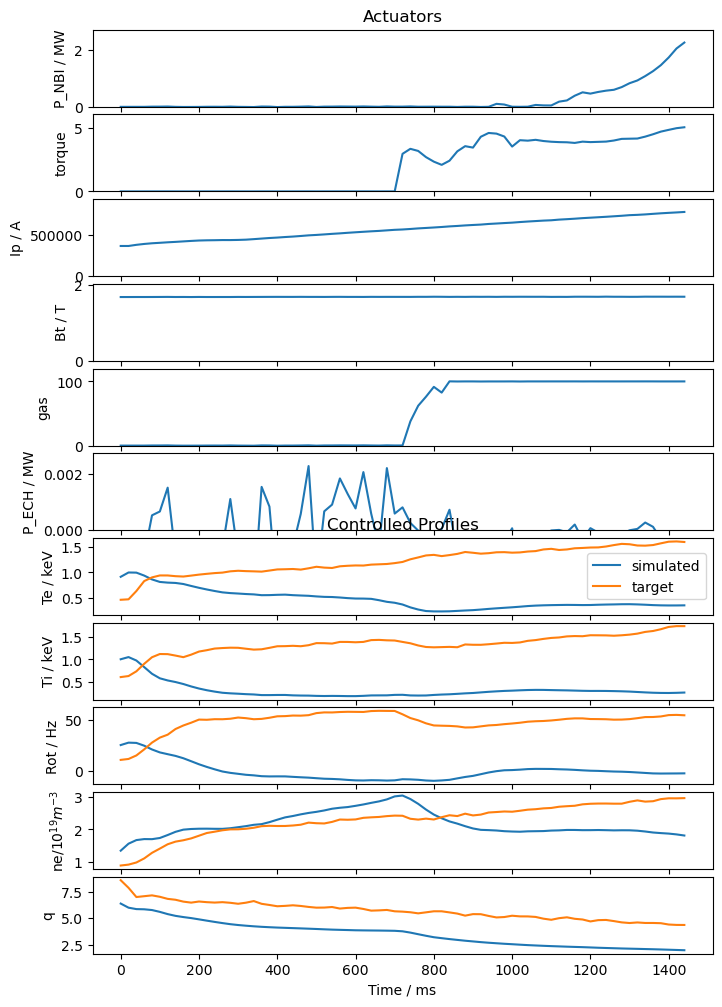

In [10]:
fig, axes = plt.subplots(nrows=len(control_model['controlled'].keys())-6, ncols=1, figsize=(8, 12), sharex=True)
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW', 'tribot', 'tritop', 'kappa', 'a', 'volume', 'R']
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW']
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
#actuator_label = controller_actuators
#profile_labels = controller_profiles
time = np.arange(len(control_model['controlled'][actuators[0]][:,0]))*20

for i, ax in enumerate(axes):
    if i < len(actuator_label):
        if actuator_label[i] == 'P_NBI / MW':
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0]/1000, label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0]/1000, label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0]/1000)*1.2)
        elif actuator_label[i] == 'P_ECH / MW':
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0]/1000000, label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0]/1000000, label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0]/1000000)*1.2)
        else:
            ax.plot(time, control_model['controlled'][controller_actuators[i]][:,0], label='controlled')
            #ax.plot(time, control_model['real'][controller_actuators[i]][:-3,0], label='experimental')
            ax.set_ylabel(f'{actuator_label[i]}')
            ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
            ax.yaxis.set_label_position('left')
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2)
    elif i < len(actuator_label) + len(controller_parameters):
        ax.plot(time, control_model['controlled'][controller_parameters[i-len(actuator_label)]])
        ax.plot(time, control_model['real'][controller_parameters[i-len(actuator_label)]][:-3])
        ax.set_ylabel(f'{actuator_label[i-len(actuator_label)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
    else:
        simulated_mean = np.mean(control_model['controlled'][controller_profiles[i - len(actuator_label) - len(controller_parameters)]][:, :], axis=1)
        real_mean = np.mean(control_model['real'][controller_profiles[i - len(actuator_label) - len(controller_parameters)]][:-3, :], axis=1)
        ax.plot(time, simulated_mean, label='simulated')
        ax.plot(time, real_mean, label='target')
        ax.set_ylabel(f'{profile_labels[i-len(actuator_label)-len(controller_parameters)]}')
        ax.tick_params(axis='y', which='both', labelleft=True, labelright=False)
        ax.yaxis.set_label_position('left')
        #ax.set_ylim(0, np.max(control_model['controlled'][controller_profiles[i - len(controller_actuators) - len(controller_parameters)]])*1.2)

# Set the x-axis label for the bottom subplot
axes[-1].set_xlabel('Time / ms')
#axes[0].legend()
axes[len(actuator_label)].legend()
axes[0].set_title('Actuators')
axes[len(actuator_label)].set_title('Controlled Profiles')
plt.subplots_adjust(hspace=0.1)
plt.savefig(f'control{lstm_model_name}{linear_model_name}{index}.png')
# Display the plot
plt.show()

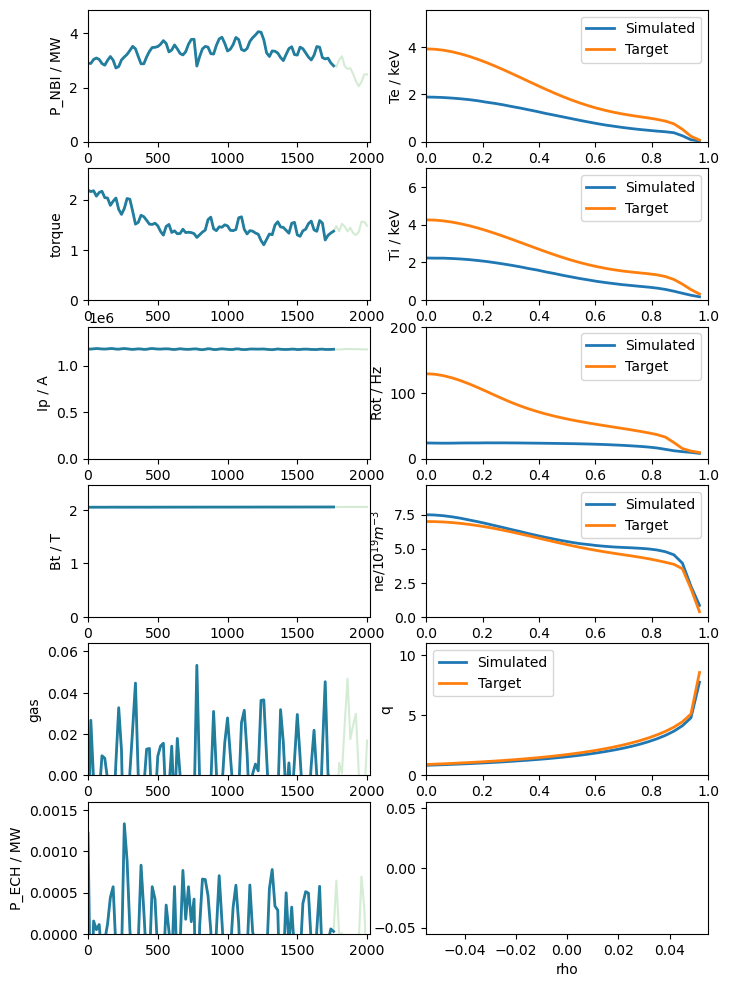

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

rhos = np.arange(33)/33
profile_labels = ['Te / keV', 'Ti / keV', 'Rot / Hz', r'ne/$10^{19}m^{-3}$', 'q']
actuator_label = ['P_NBI / MW', 'torque', 'Ip / A','Bt / T','gas', 'P_ECH / MW']
controller_actuators = controller_actuators[:6]
actuator_label = actuator_label[:6]
timetrace = control_model['controlled'][controller_actuators[0]][:,0]*1000

fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(8, 12))
#axes = axes.flatten()
axes = np.concatenate([axes[:,0], axes[:,1]], axis=0)
# Initialize line objects for each subplot
predictions = [ax.plot([], [], lw=2, label='Simulated')[0] for ax in axes]
targets = [ax.plot([], [], lw=2, label='Target')[0] for ax in axes]

# Set subplot limits and labels
for i, ax in enumerate(axes[:-1]):
    if i < len(controller_actuators):
        if actuator_label[i] == 'P_NBI / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2/1000)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:]/1000, alpha=0.2)
        elif actuator_label[i] == 'P_ECH / MW':
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2/1000000)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:]/1000000, alpha=0.2)
        else:
            ax.set_xlim(0, 20*len(timetrace))
            ax.set_ylim(0, np.max(control_model['controlled'][controller_actuators[i]][:,0])*1.2)
            ax.set_ylabel(actuator_label[i])
            ax.plot(np.arange(len(timetrace[:]))*20, control_model['controlled'][controller_actuators[i]][:,0][:], alpha=0.2)
    else:
        ax.set_xlim(0, 1)
        ax.set_ylim(0, np.max(control_model['real'][profiles[i-len(controller_actuators)]][:-3, :])*1.2)
        ax.set_ylabel(profile_labels[i-len(controller_actuators)])
        ax.legend()
axes[len(controller_actuators)].set_xlabel('Time / ms')
axes[-1].set_xlabel('rho')

#title_text = axes[0].annotate('', xy=(0.5, 1.05), xycoords='axes fraction', fontsize=10, ha='center', va='bottom')

def animate(time):
    for i in range(len(axes)-1):
        if i < len(controller_actuators):
            if actuator_label[i] == 'P_NBI / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0]/1000)
                #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['real'][controller_actuators[i]][:-3,0]/1000)
            elif actuator_label[i] == 'P_ECH / MW':
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0]/1000000)
                #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['real'][controller_actuators[i]][:-3,0]/1000000)
            else:
                predictions[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0])
            #targets[i].set_data(np.arange(len(timetrace[:time]))*20, control_model['controlled'][controller_actuators[i]][:time,0][:])
        else:
            predictions[i].set_data(rhos, control_model['controlled'][controller_profiles[i-len(controller_actuators)]][time])
            targets[i].set_data(rhos, control_model['real'][controller_profiles[i-len(controller_actuators)]][:-3][time])
    #predictions[5].set_data(np.arange(len(timetrace[:time])), timetrace[:time])

    #title_text.set_text(f'Profiles at time {time*20}ms')
    return predictions + targets

# Create the animation object
ani = animation.FuncAnimation(fig, animate, frames=90, interval=150, blit=True)
ani.save(f'{lstm_model_name}{linear_model_name}{index}.mp4', writer='ffmpeg')
# Display the animation as an HTML5 video
HTML(ani.to_html5_video())